In [1]:
import torch
import dl2_torch as d2l
import numpy as np
from torch import nn
from torch.nn import functional as F
import math

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Transformer

## 1. Attention mechianism

设想一个简单的数据库，包含 key - value 键值对，并且我们想去查找任意key对应的value，可以通过下式计算：  
$$ \textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i, $$

$\alpha(\mathbf{q}, \mathbf{k}_i)$ 表示计算 query 寻找 key 的方式，可以为相似度的计算方式。  
通过下述 exp 求和归一化的方式计算权重  
$$ \alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))} $$

### 可视化 attention weight 函数

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

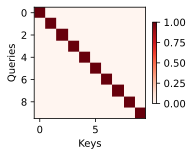

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

### attention 回归

使用attention 进行回归的原始直觉 [Nadaraya 1964][!Nadaraya, E. A. (1964). On estimating regression. Theory of Probability & its Applications, 9(1), 141–142]  

假设计算 $ y_i = 2\sin(x_i) + x_i + \epsilon $  

In [5]:
#  创建 q k v
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)  # x_train 为 key
y_train = f(x_train) + torch.randn(n)  # y_train 为 value
x_val = torch.arange(0, 5, 0.1)  # x_val 为 query
y_val = f(x_val)  # x_val 为真实值

In [6]:
#  nadaraya_watson 注意力回归
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # 每 列/行 对应 查询/健
    k = kernel(dists).type(torch.float32)
    # 在每个查询维度上进行归一化
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

#### 设定核函数   

\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechikov.}
\end{aligned}\end{split}  
注意下方核函数中的输入为 q 与 k 的差值。

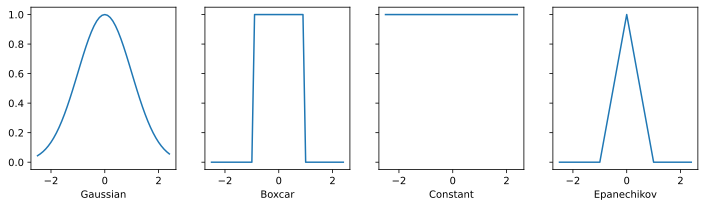

In [8]:
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

使用上述四个核计算 attention 并进行回归

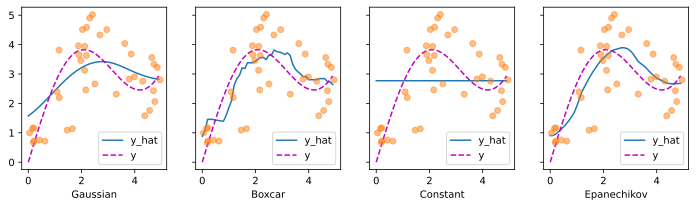

In [9]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

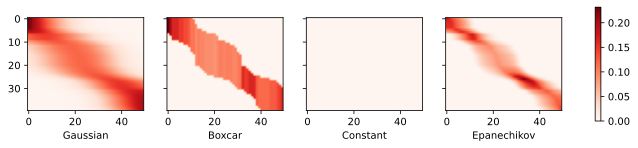

In [10]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)  # 绘制注意力图片

epanechikov 的**注意力范围**更**窄**，因此其对局部的适应性更好。而方差为1的高斯核注意力范围广， boxcar 的注意力不平滑，因此其拟合函数整体也不平滑。  
通过修改高斯分布的方差，测试其注意力变化。  $ \alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right) $

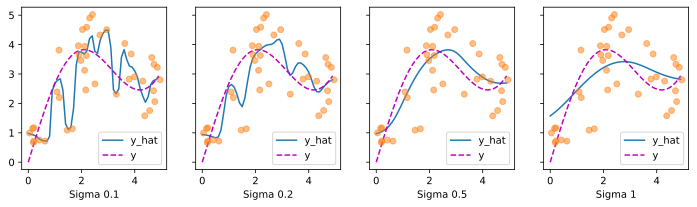

In [11]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

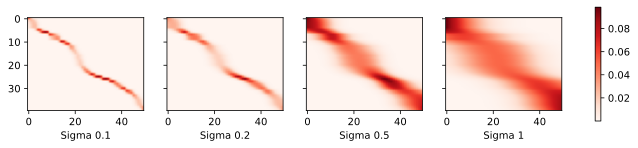

In [12]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

在这个例子上看，核越窄，估计越不平滑。同时，它能更好地适应局部变化。  
方差为 0.5 时其拟合效果最好， 对不同数据集和任务，最优注意力计算方式不同，因此可以考虑使用神经网络来拟合最优的注意力机制。

## 2. Attention function

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408281022953.png" width='600px' >
</div>

### dot attention  
推导公式， 高斯核公式如下：  
$$ a(\mathbf{q}, \mathbf{k}_i) = -\frac{1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2 = \mathbf{q}^\top \mathbf{k}_i -\frac{1}{2} \|\mathbf{k}_i\|^2 -\frac{1}{2} \|\mathbf{q}\|^2。 $$  
最后一项在softmax求权重的时候会抵消掉，直接省去；  
第二项能省去的前提是批标准化（或层标准化）所得 ki 会是一个有界且通常为常数的值，因此可以省略而没有大影响。  
假设q，k各元素独立同分布且均值为0，方差为1，为了**保持 dot product 的结果方差**仍为1，需要将结果缩放$ 1/\sqrt{d}$。  
因此注意力函数如下：  
$$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}。 $$  
规范化后得到注意力权重：  $$ \alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q) }^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d}) }。 $$

### masked softmax  
超过需要注意长度的序列其注意力为 0，通过将其值设定为-1e6 使得其exp接近为0。通过计算使其为 0 相对使用if-else执行速度更快。  



In [9]:
def masked_softmax(X, valid_lens): 
    """在X最后一个维度上进行遮罩，最后一个维度表示对应该 query 对每个key的权重.
       X: 3D tensor （batch， query_d， key_d）,
       valid_lens: 1D(batch,) or 2D (batch, query) 每个样本可以控制其中不同q的注意范围"""

    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]  # None所在维度为新增，类似unsqueeze
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])  # 重复元素， 此处将序列中的每个数字重复shape[1]次
        else:
            valid_lens = valid_lens.reshape(-1)
        # 将 X 的形状重置为 （batch*q，key），通过 broadcast 扩展为 batch，query， key
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)
    
# 测试
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))  # 分别指定 masked 维度

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3939, 0.2260, 0.3801, 0.0000]],

        [[0.6009, 0.3991, 0.0000, 0.0000],
         [0.1745, 0.3007, 0.2176, 0.3072]]])

### dot product  
假设有n个query， m个key - value 对，key 维度为d， value维度为v。  
$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}。 $$  

计算复杂度（仅统计乘法复杂度，包含转换维度的计算）：  
转换query矩阵  n*q*d*h， 转换query矩阵  n*k*d*h 计算注意力 n*q*k*h 计算value n*q*k*v

In [60]:
class DotProductAttention(nn.Module):
    """批量缩放dot product"""
    def __init__(self, dropout, hidden_nums=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden_nums = hidden_nums
        if self.hidden_nums:
            self.query_weight = nn.LazyLinear(hidden_nums, bias=False)
            self.key_weight = nn.LazyLinear(hidden_nums, bias=False)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None, norm=False):
        if self.hidden_nums:
            queries = self.query_weight(queries)
            keys = self.key_weight(keys)
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        if norm:  # 使用向量距离当作注意力分数
            #  计算 key 的模, 通过broadcast将计算所得注意力减去对应的模
            # keys_norms.shape (batchsize, 1, no. of key-value pairs)
            keys_norms = (torch.sqrt((keys ** 2).sum(-1)) / 2).reshape(keys.shape[0],1,keys.shape[1])
            #  scores.shape (batchsize, no. of queries, no. of key-value pairs)
            scores = (torch.bmm(queries, keys.transpose(1, 2)) - keys_norms) / math.sqrt(d)
        else:
            scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [67]:
queries = torch.normal(0, 1, (2, 1, 3))
keys = torch.normal(0, 1, (2, 10, 4))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5, hidden_nums=3)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


测试mask_attention

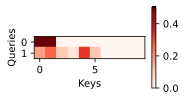

In [68]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

### additive attention   
Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. ArXiv:1409.0473.  
计算单个 q，k的公式如下, $ \mathbf W_q\in\mathbb R^{h\times q}, \mathbf W_k\in\mathbb R^{h\times k}, \mathbf w_v\in\mathbb R^{h}  $：
$$ a(\mathbf q, \mathbf k) = \mathbf w_v^\top \textrm{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R} $$  

In [4]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)  # 拓展相应的维度并相加
        # (batch_size, no. of queries, no. of key-value pairs, num_hiddens)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of queries, value dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [23]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## 3. Attention module

In [46]:
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408291954162.png" width='700px' >
</div>

下面基于 attention 的 decoder 使用下式计算centext $$ \mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_{t}) \mathbf{h}_{t}。 $$  
(i) 编码器所有时间步骤中最后一层的隐藏状态，用作注意力机制的 key 和 value；  
(ii) 编码器最后时间步骤中所有层的隐藏状态，用于初始化解码器的隐藏状态；  
(iii) 编码器的有效长度，用于排除注意力池中的填充标记。  
在每个解码时间步骤中，在前一个时间步骤中获得的解码器最后一层的隐藏状态用作注意力机制的 query。

In [72]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        # self.attention = AdditiveAttention(num_hiddens, dropout)
        self.attention = DotProductAttention(dropout=dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)  # 前一个 step 的最后一层输出作为当前层的query
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [68]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

In [49]:
class EncoderDecoder(d2l.Classifier):
    """The base class for the encoder--decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        #  args 中包含源序列长度， 由数据类提供
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

    def predict_step(self, batch, device, num_steps,
                     save_attention_weights=False):
        """Defined in :numref:`sec_seq2seq_training`"""
        batch = [d2l.to(a, device) for a in batch]
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [d2l.expand_dims(tgt[:, 0], 1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(d2l.argmax(Y, 2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return d2l.concat(outputs[1:], 1), attention_weights

In [50]:
class Seq2Seq(EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

1. 在创建数据集的过程中获得 attention 的 mask（此处为source seq长度）， 并相应返回用于 attention 计算。

In [59]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TypeError: reshape(): argument 'shape' must be tuple of ints, but found element of type float at pos 3

In [66]:
class MTFraEng(d2l.DataModule):
    """The English-French dataset."""
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super(MTFraEng, self).__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())

    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()
        
    #  预处理
    def _preprocess(self, text):
        # 将窄不换行空格 \u202f 替换为普通的空格 \xa0
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # 将文本处理成小写字母，并且将紧挨字符的标点前加入空格。
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
            for i, char in enumerate(text.lower())]
        return ''.join(out)
    
    #  tokenization
    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # 略过空的 token
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt
    
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            #  裁剪或者填充序列至相同的长度
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = d2l.Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)
    
    def get_dataloader(self, train):
        #  返回包含 原始token, encode输入， 原始序列长度， label 的数据集
        #  slice 创建切片所需的索引
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences, raw_text=None):
        if raw_text is None:
            raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays
    

In [70]:
# engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

data = MTFraEng(128)
test_data = data._download()
test_list = test_data.split('\n')[:640]
test_batch_data = data.build(None, None, ('\n').join(test_list))

preds, dec_attention_weights = model.predict_step(
    test_batch_data, d2l.try_gpu(), data.num_steps, True)

src, tgt = data._tokenize(data._preprocess(('\n').join(test_list)))
total_score = []
for en, fr, p in zip(src, tgt, preds):
    fr = ' '.join(fr[:-1])
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    total_score.append(d2l.bleu(" ".join(translation), fr, k=2))
    # print(f'{en} => {translation}, bleu,'
    #       f'{bleu(" ".join(translation), fr, k=2):.3f}')
print('mean bleu', np.mean(total_score))

mean bleu 0.3627315497189465


测试发现使用 attention的 Seq2Seq 模型 BLeu 为 0.3494 效果没有提升

使用原始 dot_prodect 训练时间没有变换，bleu变为 0.362， 推测是模型复杂度变低，减少过拟合

查看不同query 的 attention weights 不同

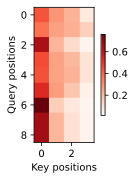

In [45]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)  # 

attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## 4. Multi-head attention

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408311928135.png" width='700px' >
</div>
  
多头注意力，实现上即将单个 hidden 头切分为 n 个 hidden / n 维度的小头。  
减小 query， key， value 维度， 从为 hidden 变为 hidden / n， 单个向量表示的信息变少了， 实际中应该保持不变，即 hidden / n == 原来的hidden。

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202408311937117.png" width='300px' >
</div> 

In [87]:
class MultiHeadAttention(d2l.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of self.W_q(queries, keys, or values):  # 使用矩阵转换后的shape
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

         # transpose_qkv 返回的张量[1 * num_heads, :, :] 是第一个样本的num_head注意力，valid_lens 也是如此 
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)  
        # valid_lens shape: num_heads * batchsize or num_heads * batchsize, no. of queries

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        # print(self.attention.attention_weights.shape)
        self.attention_weights = self.attention.attention_weights
        return self.W_o(output_concat)
    
    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)  
        X = X.permute(0, 2, 1, 3)
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])

    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)

In [88]:
class Seq2SeqAttentionDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, num_heads,
                 dropout=0):
        super().__init__()
        self.attention = MultiHeadAttention(dropout=dropout, num_hiddens=num_hiddens, num_heads=num_heads)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)  # 前一个 step 的最后一层输出作为当前层的query
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

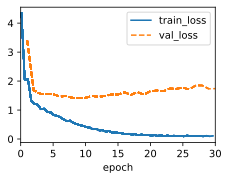

In [89]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_heads, num_layers, dropout = 256, 256, 8, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, num_heads, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [73]:
# engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
# fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

data = MTFraEng(128)
test_data = data._download()
test_list = test_data.split('\n')[:640]
test_batch_data = data.build(None, None, ('\n').join(test_list))

preds, dec_attention_weights = model.predict_step(
    test_batch_data, d2l.try_gpu(), data.num_steps, True)

src, tgt = data._tokenize(data._preprocess(('\n').join(test_list)))
total_score = []
for en, fr, p in zip(src, tgt, preds):
    fr = ' '.join(fr[:-1])
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    total_score.append(d2l.bleu(" ".join(translation), fr, k=2))
    # print(f'{en} => {translation}, bleu,'
    #       f'{bleu(" ".join(translation), fr, k=2):.3f}')
print('mean bleu', np.mean(total_score))

mean bleu 0.3480830057869847


查看第一个时间步的多个头（此处是8个）的注意力之间是否有区别

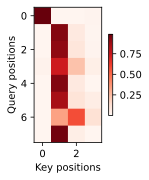

In [98]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0] for step in dec_attention_weights], 0)  # 

attention_weights = dec_attention_weights[0][0]

attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## 5. self attention and positional encoding

1. 自注意力即数据在时间步维度上均与自己相关的计算。  
2. [路径复杂度计算， attention 的顺序操作及路径长度均为O(1)， 但是其计算复杂度为$\mathcal{O}(n^2d)$, 随序列长度平方增加](https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html)

In [ ]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens),
                (batch_size, num_queries, num_hiddens))

### positional encoding

基于正弦及余弦的编码方法, i 表示 step， j 表示隐空间维度
$$ \begin{split}\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right)。\end{aligned}\end{split} $$

In [3]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个时间步足够长， 隐藏层维度相同的数组
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)  # 隐藏空间维度，奇数偶数不同仅在cos及sin
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

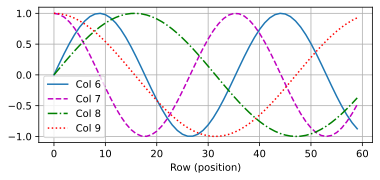

In [4]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

1. 在相同的隐空间维度上，位置编码值随着 step 周期变化， 不同的隐空间维度频率不同（相邻奇偶相同），当在step上保持一致。  
2. 在相同step上， 隐空间维度越大的位置，其曲线频率越低，因此随着隐空间维度升高其变化愈加不明显。  
3. 与 2 进制编码类似，越低位置的数其变化频率越快。
4. 除了捕获绝对位置信息外，上述位置编码还允许模型轻松学习相对位置。位置 i 与偏移位置 $ i + \delta$ 的位置编码可以通过线性变换计算。

## 6.Transformer Architecture

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202409221936543.png" width='400px' >
</div>

#### 6.1 Positionwise Feed-Forward Networks

In [2]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

#### 6.2 LayerNorm  
由于每个序列的时间步不一定相同，因此无法使用 BatchNorm， Transformer 中使用的是 LayerNorm  
LayerNorm 层归一化可以指定归一化的shape， 例如指定最后一个维度或者后两个维度  

In [7]:
ln = nn.LayerNorm((2, 2))  # 在后两个维度上进行标准化
ln_x = torch.Tensor([[[1, 2], [3, 4]], [[1, 2], [3, 4]]])
ln(ln_x)

tensor([[[-1.3416, -0.4472],
         [ 0.4472,  1.3416]],

        [[-1.3416, -0.4472],
         [ 0.4472,  1.3416]]], grad_fn=<NativeLayerNormBackward0>)

#### 6.3 Residual  ADD

In [12]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

#### 6.4 Encoder  

In [8]:
# transformer encoder block
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

why？ 由于我们使用固定位置编码，其值始终介于 -1 及 1之间，我们在将输入嵌入和位置编码相加之前，将可学习输入嵌入的值乘以嵌入维度的平方根进行缩放。  
解释： 用于扩大不同嵌入值在 -1，1 区间上的分布

In [10]:
class TransformerEncoder(d2l.Encoder):  
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))  # 根据嵌入维度对嵌入编码进行缩放
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

#### 6.5 Decoder  

In [35]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)  # 推理时每次仅预测单个时间步输出，因此要将该时间步之前预测的结果进行合并缓存到state[2]中
        state[2][self.i] = key_values
        if self.training:  # 训练时decoder的第一层自注意力计算时仅考虑该时间步之前的值
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)  # 当正式推理时，该X为上一个 step 预测值， key_values 为之前所有step的预测值
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [36]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

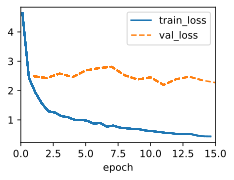

In [46]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=15, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [48]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
2
2
torch.Size([4, 1, 214])
go . => ['va', '!'], bleu,1.000
i lost . => ['je', 'suis', '<unk>', '.'], bleu,0.000
he's calm . => ['je', 'suis', 'libre', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', '.'], bleu,0.704


## 7. VIT

VIT 结构， 主要思想是将图片切块后，每个块编码按顺序编码为 num_hidden 维度的向量， 之后按照序列数据方式处理。
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202409231527118.png" width='700px' >
</div>

#### Patch Embedding

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)
        self.flatten = nn.Flatten(2)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        X = self.conv(X)
        X = self.flatten(X)
        return X.transpose(1,2)
        # return self.conv(X).flatten(2).transpose(1, 2)  # flatten 中的参数表示从第 2 个维度（即索引 2）开始，将之后所有维度展平成一维

使用 GELU 作为激活函数， 常用于 Transformer 及 BERT ，它引入了一些概率特性，表现为一种平滑的、非线性的激活方式。
其数学表达式为：
$ GELU(x)=x⋅Φ(x) $ ，其中 $ Φ(x)$ 是标准正态分布的累积分布函数（CDF），也可以通过以下近似表达式进行计算：  
$$ GELU(x)≈0.5⋅x⋅(1+tanh⁡(2/π⋅(x+0.044715⋅x3)))  $$  
直观上RELUs将输入乘以1或0，而dropout将输入随机乘以0，而GELU 随着输入x 的降低， 其期望越小，被激活的值越小。  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202409231624291.png" width='500px' >
</div>

#### ViTBlock

In [3]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))

In [4]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))

#### VIT  
1. 在最开始的时间步中加入了一个可学习的 cls_token , 该 cls_token 对所有样本都相同  
2. 将上一步合并的数据与 pos_embedding 相加获得位置参数信息， 并且需要通过 dropout 进行正则化  
3. 输出仅选取每个样本第一个 step 向量进行 label 推理。

In [5]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])  # 后面没有明确每个维度上取值的默认全部选取

#### Train

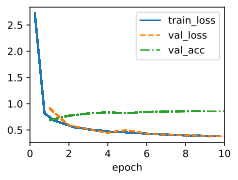

In [6]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size), num_workers=0)
trainer.fit(model, data)

因为 Transformer 缺乏卷积中那些有用的原则，如平移不变性和局部性（第 7.1 节）, VIT 并没有比传统视觉深度网络好很多。然而，当在更大的数据集（例如 3 亿张图片）上训练更大模型时，情况就不同了，视觉 Transformer 在图像分类上大幅优于 ResNet，展示了 Transformer 在可扩展性方面的内在优势（Dosovitskiy 等人，2021 年）。```Swin Transformers```|（刘等，2021 年）。

## 8. [Tranformer structure](https://d2l.ai/chapter_attention-mechanisms-and-transformers/large-pretraining-transformers.html#encoder-only)

### Encoder-only  
仅使用 transformer encoder 部分， 使用填空题方式进行训练， 可以获得前后step的信息，因此成为双向  
压缩文本内容，理解文本内容，例如基于 BERT 可以进行各种微调并将其用于下游任务。 

### Encoder-Decoder   
基于编码器和解码器的输出：  
（i）对于基于编码器输出的条件，编码器-解码器交叉注意力允许目标标记关注所有输入标记； 
（ii）通过所谓的因果注意力模式（这个名称在文献中很常见，但具有误导性，因为它与因果研究的适当研究几乎没有联系）实现基于解码器输出的条件，其中任何目标标记只能关注目标序列中的过去和当前标记。  
为了在人类标注的机器翻译数据之外预训练编码器-解码器 Transformer，BART（Lewis 等人，2019）和 T5（Text To Text Transfer Transformer）（Raffel 等人，2020）是两种同时提出的编码器-解码器 Transformer，它们在大规模文本语料库上进行了预训练。  
两者都试图在其预训练目标中重建原始文本，前者强调噪声输入（例如，掩码、删除、排列和旋转），而后者强调多任务统一，并进行了全面的消融研究。

### Decoder-only  
GPT GPT-2 

### 总结

T5 相对参数量大很多  
Encoder-Only 相对 Encoder-Decoder 预训练的不同  
T5 微调不需要额外的层，  
而 BERT 微调需要根据任务训练额外的层

Decoder-Only 相对 Encoder-Decoder 的局限  
解码器仅有的 Transformer 可能在处理多个任务或领域时遇到困难，因为它们必须为不同类型的输入和输出序列共享相同的解码器网络。这可能导致模型出现干扰或混淆，因为它必须学习不同任务或领域的不同词汇、语法和风格。编码器-解码器 Transformer 可以通过使用特定于任务或特定于领域的编码器或解码器网络来克服这一挑战，这些网络可以适应不同的输入和输出格式和需求。例如，T5 ¹使用一个文本到文本框架，通过在输入序列中添加特定于任务的词缀来处理多个自然语言处理任务，例如“将英语翻译成法语：”或“总结：”。